In [ ]:
from datasets import load_dataset
from huggingface_hub import login

login(token="") #hugging face access token
ds = load_dataset("CSALT/deepfake_detection_dataset_urdu")
print(ds)
print(ds["train"][0])  # Shows first sample
print(ds["train"].features)  # Shows available columns

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['audio'],
        num_rows: 6794
    })
})
{'audio': {'path': 'C:\\Users\\sefas\\.cache\\huggingface\\hub\\datasets--CSALT--deepfake_detection_dataset_urdu\\snapshots\\eb8f16623108324867e4424a646937409c64b82b\\Bonafide\\Speaker_01\\Part 1\\10.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00, -3.05175781e-05, ...,
        7.32421875e-04,  1.22070312e-03,  1.28173828e-03], shape=(130832,)), 'sampling_rate': 16000}}
{'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None)}


In [9]:
import numpy as np
import librosa
from tqdm import tqdm

def extract_features_with_folder_labels(dataset, n_mfcc=40, max_len=862):
    X, y = [], []

    for sample in tqdm(dataset, desc="Extracting MFCCs"):
        audio = sample["audio"]
        y_raw = audio["array"]
        sr = audio["sampling_rate"]
        path = audio["path"].lower()  # lowercased to simplify checking

        # Determine label based on folder name
        if "bonafide" in path:
            label = 0
        else:
            label = 1

        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y_raw, sr=sr, n_mfcc=n_mfcc)
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        X.append(mfcc.flatten())
        y.append(label)

    return np.array(X), np.array(y)


In [10]:
train_dataset = ds["train"]
X, y = extract_features_with_folder_labels(train_dataset)


Extracting MFCCs: 100%|██████████| 6794/6794 [02:13<00:00, 50.86it/s]


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Assuming you have X and y from feature extraction
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for SVM and Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1. SVM Classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# 2. Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# 3. MLP (Single-Layer Perceptron)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Evaluation Metrics
def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    print("AUC-ROC:", roc_auc_score(y_true, y_pred))

# Evaluate each model
print("SVM Classifier Evaluation:")
evaluate_model(y_test, y_pred_svm)

print("\nLogistic Regression Evaluation:")
evaluate_model(y_test, y_pred_lr)

print("\nMLP (Single-layer Perceptron) Evaluation:")
evaluate_model(y_test, y_pred_mlp)


SVM Classifier Evaluation:
Accuracy: 0.9477557027225901
Precision: 0.946980854197349
Recall: 0.948377581120944
F1-Score: 0.9476787030213707
AUC-ROC: 0.947757072498798

Logistic Regression Evaluation:
Accuracy: 0.9396615158204562
Precision: 0.9421364985163204
Recall: 0.9365781710914455
F1-Score: 0.9393491124260355
AUC-ROC: 0.9396547243122425

MLP (Single-layer Perceptron) Evaluation:
Accuracy: 0.9668874172185431
Precision: 0.9633967789165446
Recall: 0.9705014749262537
F1-Score: 0.9669360764144012
AUC-ROC: 0.9668953776980755


In [12]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)

print(f"Best parameters for SVM: {grid_search_svm.best_params_}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 

In [ ]:
# Hyperparameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print(f"Best parameters for Logistic Regression: {grid_search_lr.best_params_}")


In [ ]:
# Hyperparameter grid for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [200, 500]
}

grid_search_mlp = GridSearchCV(MLPClassifier(random_state=42), param_grid_mlp, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_mlp.fit(X_train, y_train)

print(f"Best parameters for MLP: {grid_search_mlp.best_params_}")


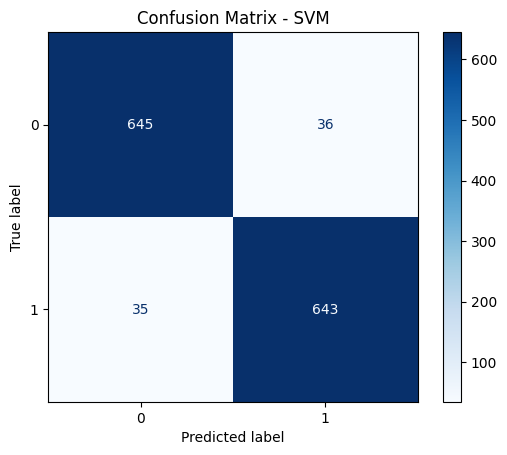

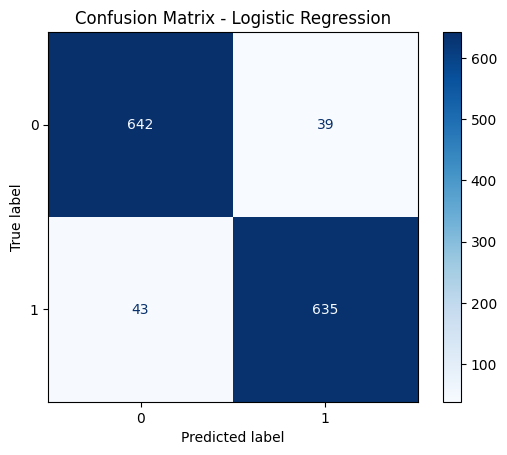

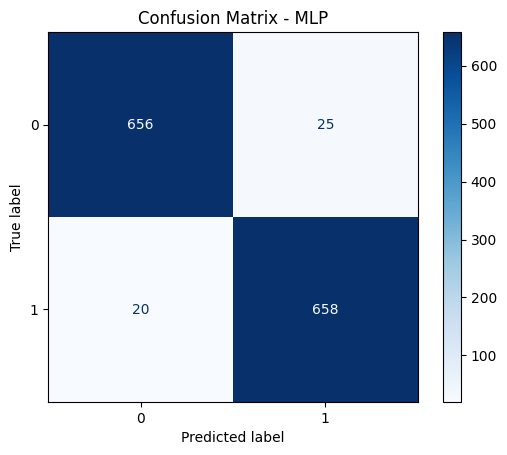

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_mlp, "MLP")


In [18]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# For SVM, Logistic Regression, MLP, you need to get probabilities
y_pred_prob_svm = grid_search_svm.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
y_pred_prob_lr = grid_search_lr.predict_proba(X_test)[:, 1]
y_pred_prob_mlp = grid_search_mlp.predict_proba(X_test)[:, 1]

# Plot ROC curves
plot_roc_curve(y_test, y_pred_prob_svm, "SVM")
plot_roc_curve(y_test, y_pred_prob_lr, "Logistic Regression")
plot_roc_curve(y_test, y_pred_prob_mlp, "MLP")


AttributeError: This 'GridSearchCV' has no attribute 'predict_proba'

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Convert features and labels to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define DNN Model (2 hidden layers)
class DNN(nn.Module):
    def __init__(self, input_size):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output: 2 classes (Bonafide/Deepfake)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
input_dim = X_train.shape[1]
model = DNN(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(10):  # You can increase epochs for better accuracy
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.2781
Epoch 2, Loss: 0.0990
Epoch 3, Loss: 0.0385
Epoch 4, Loss: 0.0386
Epoch 5, Loss: 0.0185
Epoch 6, Loss: 0.0026
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0001
Epoch 10, Loss: 0.0001


In [17]:
model.eval()
predictions = []
probabilities = []

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        predictions.extend(preds.numpy())
        probabilities.extend(probs[:, 1].numpy())  # Probability of class 1 (Deepfake)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)

print(f"DNN Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


DNN Evaluation:
Accuracy: 0.9809
Precision: 0.9780
Recall: 0.9838
F1-Score: 0.9809
AUC-ROC: 0.9967


In [21]:
from sklearn.metrics import roc_auc_score

# Function to evaluate the model with AUC-ROC
def evaluate_model_with_auc(y_true, y_pred):
    # Calculate AUC-ROC for each label
    auc_roc = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    return auc_roc

# Add AUC-ROC to the evaluation
lr_auc_roc = evaluate_model_with_auc(y_test, y_pred_lr)
print(f"Logistic Regression - AUC-ROC: {lr_auc_roc}")

svm_auc_roc = evaluate_model_with_auc(y_test, y_pred_svm)
print(f"SVM - AUC-ROC: {svm_auc_roc}")

perceptron_auc_roc = evaluate_model_with_auc(y_test, y_pred_mlp)
print(f"Perceptron - AUC-ROC: {perceptron_auc_roc}")

dnn_auc_roc = evaluate_model_with_auc(y_test, probabilities)
print(f"DNN - AUC-ROC: {dnn_auc_roc}")


Logistic Regression - AUC-ROC: 0.9396547243122425
SVM - AUC-ROC: 0.947757072498798
Perceptron - AUC-ROC: 0.9668953776980755
DNN - AUC-ROC: 0.9967426004617538


In [23]:
import dill

# Save the trained models using dill
with open('best_svm_model.pkl', 'wb') as f:
    dill.dump(svm, f)  # Save the SVM model

with open('best_logreg_model.pkl', 'wb') as f:
    dill.dump(log_reg, f)  # Save the Logistic Regression model

with open('best_mlp_model.pkl', 'wb') as f:
    dill.dump(mlp, f)  # Save the MLP (Perceptron) model

with open('best_dnn_model.pkl', 'wb') as f:
    dill.dump(model, f)  # Save the DNN model (Multi-layer Perceptron)

# Save the scaler using dill
with open('scaler.pkl', 'wb') as f:
    dill.dump(scaler, f)
